# Using UDEs to solve a damped SHO

## Generating the data

First, we'll want to generate data from a damped simple harmonic oscillator modeled by 

\begin{equation}
\frac{d^2x}{dt^2}+2\gamma\frac{dx}{dt}+\omega_0^2x=0
\label{DampedSHO}
\end{equation}

where $\gamma$ is the dampening factor and $\omega_0$ is the resonant frequency of the oscillator.

The solution to this ODE is obtained by simple using the trial solution of $x(t)=Ae^{kt}$. Plugging into the ODE we get:

\begin{equation}
\begin{split}
Ak^2e^{kt}+2\gamma Ake^{kt}+\omega_0^2Ake^{kt}&=0\\
Ae^{kt}\left(k^2+2\gamma k+\omega_0^2\right)&=0 \text{ Assume } Ae^{kt}\neq 0\\
k^2+2\gamma k+\omega_0^2&=0\\
k=\frac{-2\gamma}{2}\pm\frac{\sqrt{(2\gamma)^2-4(1)\omega_0^2}}{2}&\\
k=-\gamma\pm\sqrt{\gamma^2-\omega_0^2}
\end{split}
\label{DampedAuxEqn}
\end{equation}

So, the solution to the damped SHO is just

\begin{equation}
x(t)=A(e^{(-\gamma+\omega)t}+e^{(-\gamma-\omega)t})\text{ where } \omega=\sqrt{\gamma^2-\omega_0^2}
\label{DampedSHOSoln}
\end{equation}

and $A$ is the amplitude of oscillation.

Let's go ahead and use $\gamma=1$, $\omega_0=.5$, $A=10$ for our values to get our data.

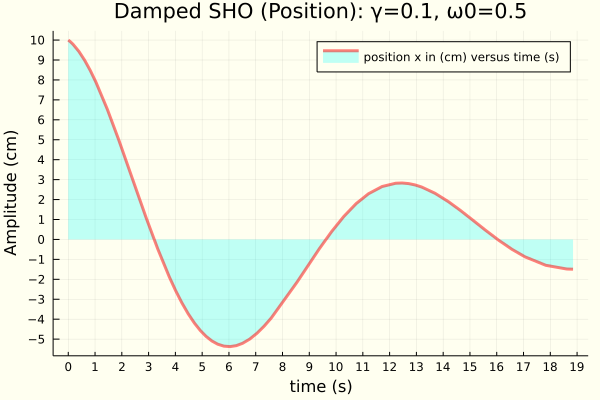

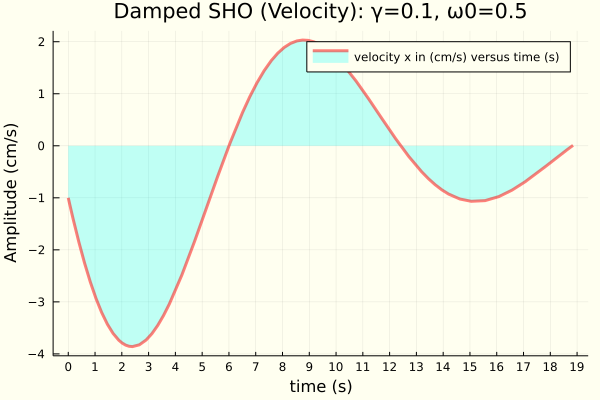

In [36]:
##using all of the packages we'll need

using Random
using Statistics
using Flux
using DiffEqFlux
using DataDrivenDiffEq
using LinearAlgebra
using DiffEqSensitivity
using Optim
using ModelingToolkit
using OrdinaryDiffEq
using Plots

#Create and store the solution to the above ODE (aka our data we want to study)

A = 10;
ω0 = .5;
γ = .1;
ω = sqrt(Complex(γ^2 - ω0^2));
Ω1 = -γ + ω;
Ω2 = -γ - ω;

#x(t)=10*exp(-γ*t)*cos(ω*t);
x(t)=(A/2)*(exp(Ω1*t) + exp(Ω2*t));
v(t)=(A/2)*(Ω1*exp(Ω1*t) + Ω2*exp(Ω2*t));

##Now make the plot to display the solution (the position)

p1=plot(
x,
    
#label the line representing x(t).
label = "position x in (cm) versus time (s)",
    
#control the line properties by making it red, with an opacity of 50%, thickness of 3, and solid.
line = (:red, 0.5, 3, :solid),
    
#start the plot at t=0 and terminate it at 6π seconds.
0,
2π*3,
    
#label axes and title the plot.
ylabel = "Amplitude (cm)",
xlabel = "time (s)",
title = "Damped SHO (Position): γ=$(γ), ω0=$(ω0)",
    
#implement numbered ticks along x,y axes in increments of 1 from 0 to 20,10.
xticks = 0:1:20,
yticks = -A:1:A,

#fill the areas between the line x(t)=0 and the plot with a cyan coloring that has 25% opacity 
    #and make the background of the plot ivory
fillrange = 0,
fillalpha = 0.25,
fillcolor = :cyan,
background_color = :ivory
)

#save the figure as a .png and .pdf
savefig("DampedSHOx.png")
savefig(p1,"DampedSHOx.pdf")

##Make the plot of the velocity

p2=plot(
v,
    
#label the line representing v(t).
label = "velocity x in (cm/s) versus time (s)",
    
#control the line properties by making it red, with an opacity of 50%, thickness of 3, and solid.
line = (:red, 0.5, 3, :solid),
    
#start the plot at t=0 and terminate it at 6π seconds.
0,
2π*3,
    
#label axes and title the plot.
ylabel = "Amplitude (cm/s)",
xlabel = "time (s)",
title = "Damped SHO (Velocity): γ=$(γ), ω0=$(ω0)",
    
#implement numbered ticks along x,y axes in increments of 1 from 0 to 20,10.
xticks = 0:1:20,
yticks = -A:1:A,

#fill the areas between the line x(t)=0 and the plot with a cyan coloring that has 25% opacity 
#and make the background of the plot ivory
fillrange = 0,
fillalpha = 0.25,
fillcolor = :cyan,
background_color = :ivory
)

##save the figure as a .png and .pdf
savefig("DampedSHOv.png")
savefig(p2,"DampedSHOv.pdf")

display(p1)
display(p2)

## Creating the UDE Model to discover damping

Now that we have the model data generated we want to learn the damping behavior without getting the solution completely from prior knowledge. When we found the solution to the damped SHO previously, we used a number of things:

<ol>
    <li>Newton's 2nd law, Hooke's Law, and assuming a damping force linearly proportional to the velocity (to form the differential equation.</li>
    <li>The well-known ansatz for a second order linear ODE with constant coefficients, $x(t)=Ae^{kt}$ and a tad bit of algebra.</li>
</ol>

The idea here is that often times in the real world you won't be able to simply look at the data, slap together an ODE with relevant boundary conditions, do some math and get an answer. However, you will have access to general properties of a system such as conservation of energy, newton'w laws etc. The point is that while we don't know everything there is to know about the system under study, we <b>DO</b> know something about what's going on. So, let's use that knowledge when making our model. The rest we'll leave up to a neural network to learn.

As a start, let's say we know that we have a data from a system involving an oscillator, we know that the data doesn't quite match up with the simple SHO, but it is SHO-like.

\begin{equation}
\frac{d^2x}{dt^2}+\omega_0^2x-NN=0
\end{equation}

Rather than one 2nd order ODE, we can recast this in terms of a system of two 1st order ODEs.

\begin{equation}
\begin{split}
\frac{dx}{dt}&=v\\
\frac{dv}{dt}&=-\omega_0^2x+NN=0
\end{split}
\end{equation}

where $NN$ is the neural network. Now let's make the <b>layers</b> of the neural network and our loss function that we'll use to discover damping.


In [46]:
##First, form the neural network

#Use a Gaussian activation function between layers of the network
rbf(t) = exp.(-(t.^2))

#Using the DiffEqFlux package define the NN
layers = FastChain(
x->[x], FastDense(1,5,rbf), FastDense(5,5,rbf), FastDense(5,5,rbf), FastDense(5,1), first
)

#Here is the loss function that we'll use to train the NN.
loss()=sum(abs2,layers(x[i])-x[i] for i in 1:length(x))

#number of points to randomly select
samplesize=100;

##Now, we're going to add some physics to the loss function
#Make an array of random values of length(x) in range of [-A,A]
random_positions = [];
for i in 1:samplesize
    push!(random_positions,A*(2*rand()-1));
end

phyloss()=sum(abs2,layers(x)-(-k*x) for x in random_positions)

#weight term associated with phyloss
λ = 0.1

#the total loss of with physics included
composed_loss() = loss() + λ*phyloss()

composed_loss (generic function with 1 method)

Now to train the model.

In [66]:
opt = Flux.Descent(0.01)
data = Iterators.repeated((), 5000)
iter = 0
cb = function () #callback function to observe training
  global iter += 1
  if iter % 500 == 0
    display(composed_loss())
  end
end

#display(composed_loss())
#Flux.train!(composed_loss, Flux.params(layers), data, opt; cb=cb)

#learned_plot = layers(x)

#plot(t,x,xlabel="t",label="True Position")
#plot!(t,learned_plot,label="Predicted Force")

#143 (generic function with 1 method)